<a href="https://colab.research.google.com/github/RobinfRoth/ip5/blob/main/llm_model3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [3]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

ajshaseewer_raw_dataset_path = kagglehub.dataset_download('ajshaseewer/raw-dataset')
ajshaseewer_challenge_description_path = kagglehub.dataset_download('ajshaseewer/challenge-description')
robinroth_finetuned_llm_one_word_prediction_path = kagglehub.dataset_download('robinroth/finetuned-llm-one-word-prediction')
metaresearch_llama_3_2_transformers_3b_instruct_1_path = kagglehub.model_download('metaresearch/llama-3.2/Transformers/3b-instruct/1')

print('Data source import complete.')


Data source import complete.


# Model 4 - Finetune LLAMA using Lora and a Classification Head

## 1. Setup

In [4]:
%%capture
%pip install -U --upgrade transformers==4.45.2
%pip install -U datasets
%pip install -U accelerate
%pip install -U peft
%pip install -U trl
%pip install -U bitsandbytes
%pip install -U wandb
%pip install -U scikit-learn
%pip install -U evaluate
%pip install -U iterative-stratification

In [5]:
import os
import evaluate
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
from google.colab import userdata

TRAIN_MODEL = True
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [6]:
from transformers import (
    AutoModelForSequenceClassification,
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    Trainer,
    pipeline,
    logging,
    EarlyStoppingCallback,
    DataCollatorWithPadding,
)
from peft import (
    LoraConfig,
    PeftModel,
    prepare_model_for_kbit_training,
    get_peft_model,
)
import os, torch, wandb, json
from datasets import load_dataset
from datasets import Dataset
from trl import SFTTrainer, setup_chat_format, SFTConfig

In [7]:
from huggingface_hub import login
from google.colab import userdata
hf_token = userdata.get("HUGGINFACE_TOKEN")
login(token = hf_token)

In [8]:
wb_token = userdata.get("wandb")

wandb.login(key=wb_token)
run = wandb.init(
    project='Fine-tune Llama 3.2 on Student Programming Projects',
    job_type="training",
    anonymous="allow"
)

wandb: Currently logged in as: robin-roth1 (robin-roth1-fhnw). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [9]:
base_model = metaresearch_llama_3_2_transformers_3b_instruct_1_path
results_path = "results"
new_model = "llama-3.2-3b-it-programming-projects-V7"

dataset_name = ajshaseewer_raw_dataset_path + "/raw_dataset.csv"

# Importing the dataset
df = pd.read_csv(dataset_name)
challenge_names = df.columns[7:].to_list()

challenge_description = pd.read_csv(ajshaseewer_challenge_description_path + "/Frogger.csv")
challenge_dict = { k:v for k, v in zip(challenge_description.to_dict()["Challenge Name"].values(),
                                       challenge_description.to_dict()["Challenge description"].values()) }
label_names = challenge_names
classes = [ c for c in label_names ]
class2id = { c:id for id, c in enumerate(classes) }
id2class = { id:c for c, id in class2id.items() }

## 2. Loading the model, tokenizer and define metrics

In [10]:
# QLoRA config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
)
# Load model
model = AutoModelForSequenceClassification.from_pretrained(
    base_model,
    quantization_config=bnb_config,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    return_dict=True,
    num_labels=len(classes),
    id2label=id2class,
    label2id=class2id,
    problem_type="multi_label_classification",
)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)

# Prepare data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at /root/.cache/kagglehub/models/metaresearch/llama-3.2/Transformers/3b-instruct/1 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
from sklearn.metrics import f1_score
import torch

def compute_metrics(eval_pred):
    logits = eval_pred.predictions
    labels = eval_pred.label_ids

    sigmoid = torch.nn.Sigmoid()

    predictions = sigmoid(torch.Tensor(logits))
    y_pred = np.zeros(predictions.shape)
    y_pred[np.where(predictions >= 0.5)] = 1

    y_true = labels.astype(np.int32)

    f1_micro = f1_score(y_true=y_true, y_pred=y_pred, average='micro', zero_division=np.nan)
    f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro', zero_division=np.nan)

    return {'f1_micro': f1_micro, 'f1_macro': f1_macro}

## 3. Loading and processing of the dataset

### Split Dataset in Train- and Testdataset

In [12]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

df_labels_only = df.iloc[:, 7:]
xml_code_only_with_label = pd.concat([df["xml_code"], df_labels_only], axis=1)

#split dataset
mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#spilt train and test
for train_idx, test_idx in mskf.split(xml_code_only_with_label, df_labels_only):
    df_train = xml_code_only_with_label.iloc[train_idx]
    df_test = xml_code_only_with_label.iloc[test_idx]

In [13]:
def preprocess_labels(row):
    row['labels'] =  row[label_names].astype("float").to_list()
    return row

def apply_preprocessing_per_df(df):
    # remove floats from xml
    df.loc[:, "xml_code"] = df["xml_code"].str.replace(r"[\dD]+(\.[\dD]+)+", "", regex=True)
    # replace file separator by a newline
    df.loc[:, "xml_code"] = df["xml_code"].str.replace("%", "\n")

    df = df.apply(preprocess_labels, axis=1)
    return df

In [14]:
df_train = apply_preprocessing_per_df(df_train)
df_test = apply_preprocessing_per_df(df_test)

### Use a MultiLabel Classification Head

In [15]:
def tokenize_data(example):
    result = tokenizer(example["xml_code"], truncation=True, max_length=2048)
    result["labels"] = example["labels"]
    return result

In [16]:
ds_train = Dataset.from_pandas(df_train[["xml_code", "labels"]])
ds_test = Dataset.from_pandas(df_test[["xml_code", "labels"]])

ds_train = ds_train.map(tokenize_data, batched=True, remove_columns=["xml_code"])
ds_test = ds_test.map(tokenize_data, batched=True, remove_columns=["xml_code"])

Map:   0%|          | 0/303 [00:00<?, ? examples/s]

Map:   0%|          | 0/75 [00:00<?, ? examples/s]

In [17]:
# Sample of the set
ds_train

Dataset({
    features: ['labels', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 303
})

## 4. Setting up The Model and Finetune it

In [18]:
import bitsandbytes as bnb

def find_all_linear_names(model):
    cls = bnb.nn.Linear4bit
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])
    if 'lm_head' in lora_module_names:  # needed for 16 bit
        lora_module_names.remove('lm_head')
    return list(lora_module_names)

modules = find_all_linear_names(model)

In [24]:
# LoRA config
peft_config = LoraConfig(
    r=8, # rank = how much of the models weights are adjusted
    lora_alpha=32,
    lora_dropout=0.2,
    bias="none",
    task_type="SEQ_CLS",
    target_modules=["lm_head", "q_proj", "v_proj"],  #modules,
)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

# set pad_token_id
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.pad_token_id

trainable params: 2,336,768 || all params: 3,215,129,600 || trainable%: 0.0727


In [20]:
# Hyperparamters
training_arguments = TrainingArguments(
    output_dir=results_path,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=16,
    optim="adamw_torch",
    lr_scheduler_type="linear",
    num_train_epochs=10,
    eval_strategy="steps",
    save_strategy="steps",
    save_steps=5,
    eval_accumulation_steps=1,
    logging_steps=5,
    warmup_steps=10,
    logging_strategy="steps",
    learning_rate=2e-4,
    group_by_length=True,
    report_to="wandb",
    metric_for_best_model="f1_macro",
    load_best_model_at_end=True,
)

In [21]:
# Setting parameters
trainer = Trainer(
    model=model,
    train_dataset=ds_train,
    eval_dataset=ds_test,
    processing_class=tokenizer,
    args=training_arguments,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [22]:
print(ds_test["labels"])

[[0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0], [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0], [1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [23]:
if TRAIN_MODEL:
    trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss,Validation Loss,F1 Micro,F1 Macro
5,0.992100,0.915493,0.370000,0.286892
10,0.720400,0.569435,0.485714,0.245116
15,0.506800,0.493979,0.566929,0.223802
20,0.434100,0.451026,0.569170,0.227895
25,0.408300,0.440375,0.555556,0.218158
30,0.390700,0.437210,0.554371,0.195583
35,0.406800,0.440360,0.564797,0.224082
40,0.334600,0.449339,0.556213,0.213241
45,0.371700,0.454844,0.533881,0.204773


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:230: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:230: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trai

In [25]:
def plot_loss(training_loss: list[float], validation_loss: list[float]) -> None:
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    # training loss
    axes[0].plot(range(0, len(training_loss)), training_loss, label='Training Loss', marker='o', color="blue")
    axes[0].set_xlabel('Iterations', fontsize=14)
    axes[0].set_ylabel('Loss', fontsize=14)
    axes[0].set_title('Loss Function During Training', fontsize=16)
    axes[0].grid(True, linestyle='--', alpha=0.6)
    axes[0].legend(fontsize=12)

    # validation loss
    axes[1].plot(range(0, len(validation_loss)), validation_loss, label='Validation Loss', marker='s', color="orange")
    axes[1].set_xlabel('Iterations', fontsize=14)
    axes[1].set_title('Loss Function During Validation', fontsize=16)
    axes[1].grid(True, linestyle='--', alpha=0.6)
    axes[1].legend(fontsize=12)

    # Show the plot
    plt.tight_layout()
    plt.show()

eval/f1_macro,█▅▃▃▃▁▃▂▂
eval/f1_micro,▁▅███▇██▇
eval/loss,█▃▂▁▁▁▁▁▁
eval/runtime,▁█▄▆▅▄▆▇▆
eval/samples_per_second,█▁▄▃▄▅▃▂▃
eval/steps_per_second,█▁▅▃▅▅▃▂▃
train/epoch,▁▁▂▂▃▃▄▄▄▄▅▅▆▆▇▇███
train/global_step,▁▁▂▂▃▃▄▄▅▅▅▅▆▆▇▇███
train/grad_norm,█▂▄▁▂▂▁▁▂
train/learning_rate,▁█▇▆▅▅▄▃▂
train/loss,█▅▃▂▂▂▂▁▁


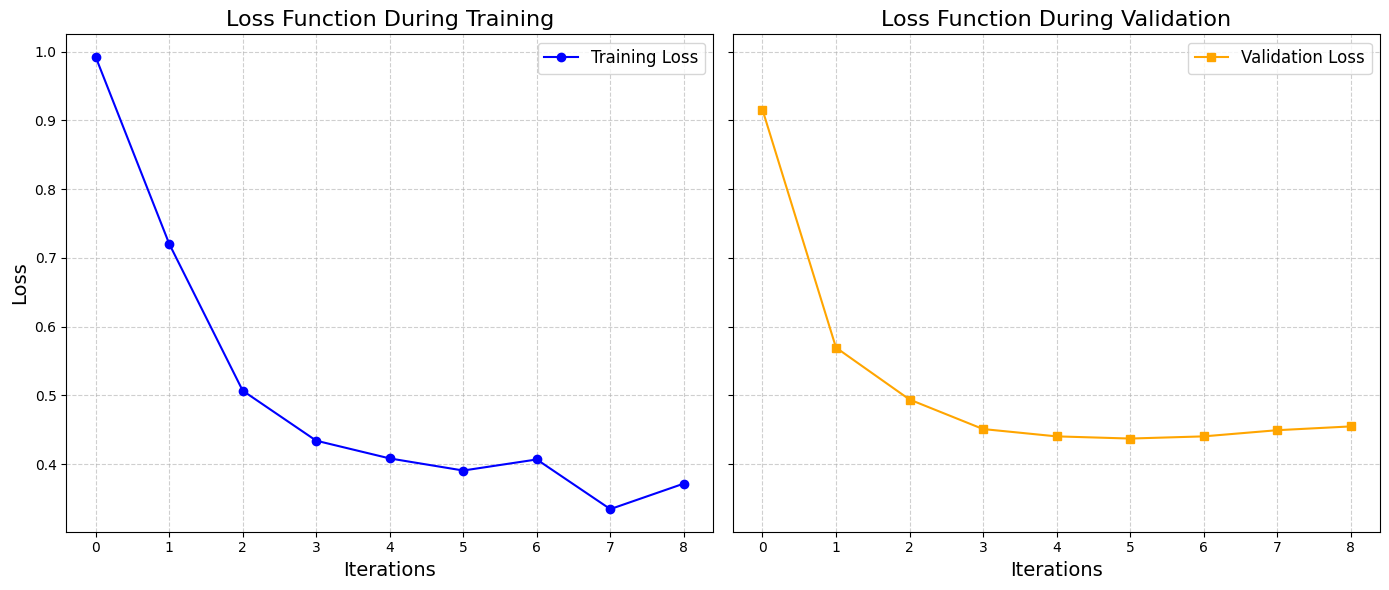

In [26]:
if TRAIN_MODEL:
    wandb.finish()

    train_loss = []
    val_loss = []
    for elem in trainer.state.log_history:
        if "loss" in elem.keys():
            train_loss.append(elem["loss"])
        if "eval_loss" in elem.keys():
            val_loss.append(elem["eval_loss"])

    plot_loss(train_loss, val_loss)

In [27]:
if TRAIN_MODEL:
    best_checkpoint_dir = trainer.state.best_model_checkpoint
    print(f"Best model checkpoint saved at: {best_checkpoint_dir}")
    best_model = trainer.model
    best_model.save_pretrained(new_model)
    trainer.tokenizer.save_pretrained(new_model)

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:230: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Best model checkpoint saved at: results/checkpoint-20


## 5. Evaluate

In [32]:
base_mode_url = base_model
finetuned_model_path = "/content/llama-3.2-3b-it-programming-projects-V7"

base_model_reload = AutoModelForSequenceClassification.from_pretrained(
    base_mode_url,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True,
    num_labels=len(classes),
    id2label=id2class,
    label2id=class2id,
    problem_type="multi_label_classification",
)

best_tokenizer = AutoTokenizer.from_pretrained(base_mode_url)
best_tokenizer.pad_token = best_tokenizer.eos_token

# Merge adapter with base model
best_model = PeftModel.from_pretrained(base_model_reload, finetuned_model_path)
best_model_complete = best_model.merge_and_unload()
best_model_complete.config.pad_token_id = best_tokenizer.pad_token_id

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at /root/.cache/kagglehub/models/metaresearch/llama-3.2/Transformers/3b-instruct/1 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
training_arguments.eval_strategy = "no"

def compute_metrics_eval(eval_pred):
    logits = eval_pred.predictions
    labels = eval_pred.label_ids

    sigmoid = torch.nn.Sigmoid()

    predictions = sigmoid(torch.Tensor(logits))
    y_pred = np.zeros(predictions.shape)
    y_pred[np.where(predictions >= 0.5)] = 1

    y_true = labels.astype(np.int32)

    f1_micro = f1_score(y_true=y_true, y_pred=y_pred, average='micro', zero_division=np.nan)
    f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro', zero_division=np.nan)

    scores_per_label = f1_score(y_true, y_pred, average=None, zero_division=np.nan).tolist()

    f1_per_label = { l:s for l, s in zip(label_names, scores_per_label) }

    return {'f1_micro': f1_micro, 'f1_macro': f1_macro, 'f1_per_label': f1_per_label}

In [34]:
trainer = Trainer(
    model=best_model_complete,
    tokenizer=best_tokenizer,
    args=training_arguments,
    data_collator=data_collator,
    compute_metrics=compute_metrics_eval,
)

<ipython-input-34-b16e870e46d9>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [35]:
test_results = trainer.evaluate(eval_dataset=ds_test)

# Print evaluation results
print("Test Set Evaluation Results:")
for key, value in test_results.items():
    print(f"{key}: {value}")


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Test Set Evaluation Results:
eval_loss: 0.9981971979141235
eval_model_preparation_time: 0.0048
eval_f1_micro: 0.35377358490566035
eval_f1_macro: 0.28293329443960713
eval_f1_per_label: {'selbstgezeichnete_agenten': 0.7457627118644068, 'richtungswechsel_frosch': 0.4533333333333333, 'animierter_frosch': 0.0, 'startscreen': 0.0, 'hauptfigur_selbstgezeichnet_und_formwechsel': 0.4444444444444444, 'cheaten_wird_verhindert': 0.38095238095238093, 'neues_level': 0.22857142857142856, 'drei_leben': 0.06557377049180328, 'fallen_eingebaut': 0.48484848484848486, 'hindernisse_von_beiden_seiten': 0.463768115942029, 'tiere_als_gegner': 0.09230769230769231, 'timer': 0.0, 'lava_oder_fluss_mit_transport': 0.3157894736842105, 'zusätzliche_hindernisse': 0.2857142857142857}
eval_runtime: 13.8467
eval_samples_per_second: 5.416
eval_steps_per_second: 1.372


## 6. Loading Finetuned Model

In [ ]:
# Load the pipeline
pipe = pipeline("text-classification", model=model, tokenizer=tokenizer, top_k=None) # top_k=None shows all predictions

idx = 2
row = df_test.iloc[idx]
xml_code = row["xml_code"]
labels = row.iloc[7:-1]

# Get predictions
predictions = pipe(xml_code)
print(predictions)
print(f"Ground truth:\n {labels}")